In [1]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot, plot_plotly, add_changepoints_to_plot, plot_forecast_component, plot_cross_validation_metric
import numpy as np
import pandas as pd
import dagstermill as dm
from dagster import ExpectationResult, EventMetadataEntry
import snowflake.connector
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import time
import datetime as dt

Importing plotly failed. Interactive plots will not work.


In [2]:
# Parameters (replaced by Dagster in production)

SNOWFLAKE_USER = os.environ["SNOWFLAKE_USER"]
SNOWFLAKE_PASSWORD = os.environ["SNOWFLAKE_PASSWORD"]
SNOWFLAKE_ACCOUNT = os.environ["SNOWFLAKE_ACCOUNT"]

with snowflake.connector.connect(user=SNOWFLAKE_USER, password=SNOWFLAKE_PASSWORD, account=SNOWFLAKE_ACCOUNT) as conn:
    orders = conn.cursor().execute("SELECT * FROM ANALYTICS.REPORTING.CUSTOMER_ORDERS").fetch_pandas_all()
    campaigns = conn.cursor().execute("SELECT * FROM MODELS.DATA_SCIENCE.DATA_SCIENCE_MARKETING_CAMPAIGN_FEATURES").fetch_pandas_all()

In [3]:
# Transforms

orders.columns = map(str.lower, orders.columns)
orders = orders.rename(columns={"calendar_date": "ds", "fulfillments": "y", "day": "dom"})

campaigns.columns = map(str.lower, campaigns.columns)

### Define functions for custom flags

Weekly seasonality is different due to covid behavior
- Pre covid until 03/01/2020
- Covid 03/01/2020 - 05/30/2020
- Post covid 06/01/2020 onwards
"""

In [4]:
def pre_covid(ds):
    return (ds < "2020-03-01")

def is_covid(ds):
    return (ds >= "2020-03-01" and ds < "2020-06-01")

def post_covid(ds):
    return (ds >= "2020-06-01")

def pre_2020(ds):
    return (ds < '2020-01-01')

def post_2020(ds):
    return (ds >= '2020-01-01' and ds < "2021-01-01")

def post_2021(ds):
    return (ds >= '2021-01-01')

### Cleaning & Transformation

In [5]:
# cleaning
orders = orders.astype({"ds": "datetime64[ns]"})

# correct thanksgiving 2019 value
orders.loc[orders["ds"].isin(pd.to_datetime(["2019-11-28"])), "y"] = 0

# correct new years value
orders.loc[orders["ds"].isin(pd.to_datetime(["2017-01-01", "2018-01-01", "2019-01-01", "2020-01-01"])), "y"] = 0

# set closed for new years
orders.loc[orders["ds"].isin(pd.to_datetime(["2017-01-01", "2018-01-01", "2019-01-01", "2020-01-01", "2021-01-01"])), "is_closed"] = True

# correct holiday flags
orders.loc[orders["ds"].isin(pd.to_datetime(["2017-01-01"])), "is_holiday"] = True
orders.loc[orders["ds"].isin(pd.to_datetime(["2017-01-02"])), "is_holiday"] = False

# three day weekends
orders.loc[:, "is_monday_holiday"] = False
orders.loc[:, "is_friday_holiday"] = False
orders.loc[(~orders.is_closed) & (orders.is_holiday) & (orders.dow == 1), "is_monday_holiday"] = True
orders.loc[(~orders.is_closed) & (orders.is_holiday) & (orders.dow == 5), "is_friday_holiday"] = True

orders.loc[:, "three_day_weekend"] = False
orders.loc[(orders.is_monday_holiday) | (orders.is_friday_holiday), "three_day_weekend"] = True

holiday_weekend_dates = [] # list for staurday and sunday after or before holiday
holiday_weekend_dates.append(orders[(orders.three_day_weekend) & (orders.dow == 1)].ds - dt.timedelta(days=1))
holiday_weekend_dates.append(orders[(orders.three_day_weekend) & (orders.dow == 1)].ds - dt.timedelta(days=2))
holiday_weekend_dates.append(orders[(orders.three_day_weekend) & (orders.dow == 5)].ds + dt.timedelta(days=1))
holiday_weekend_dates.append(orders[(orders.three_day_weekend) & (orders.dow == 5)].ds + dt.timedelta(days=2))

flattened = [val for sublist in holiday_weekend_dates for val in sublist]

orders.loc[orders["ds"].isin(flattened), "three_day_weekend"] = True

# add covid flags
orders["ds"] = orders["ds"].astype(str)
orders.loc[:,"pre_covid"] = orders["ds"].apply(pre_covid)
orders.loc[:,"is_covid"] = orders["ds"].apply(is_covid)
orders.loc[:,"post_covid"] = orders["ds"].apply(post_covid)

orders.loc[:,'pre_2020'] = orders['ds'].apply(pre_2020)
orders.loc[:,'post_2020'] = orders['ds'].apply(post_2020)
orders.loc[:,'post_2021'] = orders['ds'].apply(post_2021)

In [6]:
# sort orders by datetime
orders = orders.astype({"ds": "datetime64[ns]"})
orders.sort_values(by=["ds"],inplace=True)

# reset index
orders.reset_index(drop=True, inplace=True)

# prepare dataframe for model fit
orders = orders[~orders.is_closed]
orders.sort_values(by=["ds"],inplace=True)

today = dt.date.today()
three_weeks_out =  today + dt.timedelta(weeks=3)
orders = orders[orders['ds'] < pd.to_datetime(three_weeks_out)] # Restrict orders for 3 weeks out

input_df = pd.DataFrame()
input_df = orders.loc[:, ["ds", "y", "three_day_weekend", "pre_covid", "is_covid", "post_covid", "pre_2020", "post_2020", "post_2021"]].copy()

# boxcox transformation
input_df.loc[:,"y"], lam = boxcox(input_df.loc[:,"y"] + 1)

# sort orders by datetime
input_df.sort_values(by=["ds"],inplace=True)

# reset index
input_df.reset_index(drop=True, inplace=True)

In [7]:
# QC

# check for null values
print("date null: ", input_df["ds"].isnull().any())
print("value null: ", input_df["y"].isnull().any())

# check min max dates
print("max date: ", max(input_df["ds"]))
print("min date: ", min(input_df["ds"]))

date null:  False
value null:  False
max date:  2021-05-17 00:00:00
min date:  2017-01-02 00:00:00


### Create Holiday DataFrames

### Create ParameterGrid

#### Fourier order
- Default to 3 for weekly seasonality
- Default to 10 for yearly seasonality
- Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting
- N Fourier terms corresponds to 2N variables used for modeling the cycle

#### Prior scale
- Default to 10
- Increasing prior scale will allow this seasonality component more flexibility, decreasing will dampen it
- Seasonality prior scale is setting the standard deviation for the normal distribution

In [8]:
# holidays

thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2017-11-23', '2018-11-22', '2019-11-28', '2020-11-26']),
  'lower_window': -3,
  'upper_window': 2
})

christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25', '2020-12-25']),
  'lower_window': -1,
  'upper_window': 5
})

newyear = pd.DataFrame({
  'holiday': 'newyear',
  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01']),
  'lower_window': -1,
  'upper_window': 5
})

is_monday_holiday = pd.DataFrame({
  'holiday': 'is_monday_holiday',
  'ds': pd.to_datetime(orders[orders.is_monday_holiday].ds.values),
  'lower_window': -3,
  'upper_window': 0
})

is_friday_holiday = pd.DataFrame({
  'holiday': 'is_friday_holiday',
  'ds': pd.to_datetime(orders[orders.is_friday_holiday].ds.values),
  'lower_window': 0,
  'upper_window': 3
})

holidays_value = pd.concat((thanksgiving, christmas, newyear))
holidays_value.reset_index(drop=True, inplace=True)

# hyper parameters
"""
Fourier order
- Default to 3 for weekly seasonality
- Default to 10 for yearly seasonality
- Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting
- N Fourier terms corresponds to 2N variables used for modeling the cycle

Prior scale
- Default to 10
- Increasing prior scale will allow this seasonality component more flexibility, decreasing will dampen it
- Seasonality prior scale is setting the standard deviation for the normal distribution

"""
params_grid = {'holidays':[holidays_value],
               'holidays_prior_scale':[5],
               # 'seasonality_mode':['multiplicative'],
               'daily_seasonality':[False],
               'weekly_seasonality':[False],
               'yearly_seasonality':[False],
               # 'seasonality_prior_scale':[10],
               
               'growth':['linear'],
               
               'changepoints':[None],
               'n_changepoints':[50],
               'changepoint_range':[0.9],
               'changepoint_prior_scale':[0.05],
               
               'mcmc_samples':[0],
               'interval_width':[0.8],
               'uncertainty_samples':[1000]
                }
grid = ParameterGrid(params_grid)

### Model Training

In [9]:
best_parameter=None
best_model=None
best_cv_results=None
best_forecast=None
best_prior_scale=None
best_error=np.inf
prior_scale=None
tic = time.time()

# Fit the model using grid search
for prior_scale in [0.1]:
    
    for parameters in grid:
        
        m = Prophet(**parameters)
        
        m.add_regressor('three_day_weekend', prior_scale=None, standardize='auto', mode='multiplicative')
        
        m.add_seasonality(name='pre_covid_weekly', period=7, fourier_order=3, prior_scale=prior_scale, mode='multiplicative', condition_name='pre_covid')
        m.add_seasonality(name='is_covid_weekly', period=7, fourier_order=3, prior_scale=prior_scale, mode='multiplicative', condition_name='is_covid')
        m.add_seasonality(name='post_covid_weekly', period=7, fourier_order=3, prior_scale=prior_scale, mode='multiplicative', condition_name='post_covid')
        
        m.add_seasonality(name='pre_2020', period=365.25, fourier_order=10, prior_scale=0.01, mode='multiplicative', condition_name='pre_2020')
        m.add_seasonality(name='post_2020', period=365.25, fourier_order=10, prior_scale=0.01, mode='multiplicative', condition_name='post_2020')
        m.add_seasonality(name='post_2021', period=365.25, fourier_order=10, prior_scale=0.01, mode='multiplicative', condition_name='post_2021')

        m.fit(input_df[input_df['ds'] < pd.to_datetime(today)])
        
        future = input_df[['ds']]
        
        # Add flags
        future['ds'] = future['ds'].astype(str)
        future.loc[:,'pre_covid'] = future['ds'].apply(pre_covid)
        future.loc[:,'is_covid'] = future['ds'].apply(is_covid)
        future.loc[:,'post_covid'] = future['ds'].apply(post_covid)
        
        future.loc[:,'pre_2020'] = future['ds'].apply(pre_2020)
        future.loc[:,'post_2020'] = future['ds'].apply(post_2020)
        future.loc[:,'post_2021'] = future['ds'].apply(post_2021)

        future['three_day_weekend'] = input_df['three_day_weekend']

        forecast = m.predict(future)
        
        cv_results = cross_validation(m, initial='365.25 days', period='7 days', horizon='21 days')
        metric_7days = performance_metrics(cv_results).mae.mean()
        
        if metric_7days < best_error:
            best_error = metric_7days
            best_model = m
            best_prior_scale = prior_scale

            best_cv_results = pd.DataFrame()
            best_cv_results = cv_results.copy()
            best_forecast = pd.DataFrame()
            best_forecast = forecast.copy()

            print('metric_7days: ', metric_7days)
            best_parameter = parameters
            
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

<ipython-input-9-cc193931b954>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['ds'] = future['ds'].astype(str)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be s

  0%|          | 0/170 [00:00<?, ?it/s]

metric_7days:  12.824014284226331
Minutes taken = 6.97


In [10]:
# Display best parameter
best_parameter

{'changepoint_prior_scale': 0.05,
 'changepoint_range': 0.9,
 'changepoints': None,
 'daily_seasonality': False,
 'growth': 'linear',
 'holidays':          holiday         ds  lower_window  upper_window
 0   thanksgiving 2017-11-23            -3             2
 1   thanksgiving 2018-11-22            -3             2
 2   thanksgiving 2019-11-28            -3             2
 3   thanksgiving 2020-11-26            -3             2
 4      christmas 2017-12-25            -1             5
 5      christmas 2018-12-25            -1             5
 6      christmas 2019-12-25            -1             5
 7      christmas 2020-12-25            -1             5
 8        newyear 2017-01-01            -1             5
 9        newyear 2018-01-01            -1             5
 10       newyear 2019-01-01            -1             5
 11       newyear 2020-01-01            -1             5
 12       newyear 2021-01-01            -1             5,
 'holidays_prior_scale': 5,
 'interval_width': 0.8,
 'm

In [11]:
# Display best prior scale
best_prior_scale

0.1

In [12]:
# Cross validation results
best_cv_results.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
3538,2021-04-22,261.794980,248.105114,275.844031,213.149596,2021-04-05
3539,2021-04-23,291.169228,277.502963,305.742166,238.229683,2021-04-05
3540,2021-04-24,234.939759,221.693648,248.141524,200.887635,2021-04-05
3541,2021-04-25,265.146596,251.905171,279.211385,232.637978,2021-04-05
3542,2021-04-26,281.755235,267.706886,295.209653,245.255960,2021-04-05


In [13]:
# Performance metrics
performance_metrics(best_cv_results)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,196.545922,14.019484,9.979472,0.056545,0.046292,0.725098
1,4 days,266.390744,16.321481,11.050568,0.063740,0.045814,0.689013
2,5 days,254.099466,15.940498,10.918094,0.063713,0.045908,0.687845
3,6 days,211.083442,14.528711,11.166118,0.059875,0.048503,0.633239
4,7 days,240.687114,15.514094,11.613160,0.056896,0.043712,0.604653
5,8 days,283.970084,16.851412,11.661496,0.057214,0.039974,0.649020
6,9 days,306.979572,17.520833,12.172819,0.062857,0.046805,0.651844
7,10 days,308.048822,17.551320,12.323267,0.067916,0.050185,0.667911
8,11 days,410.445891,20.259464,13.804086,0.077508,0.051123,0.647817
9,12 days,385.358573,19.630552,13.286444,0.076230,0.054025,0.652593


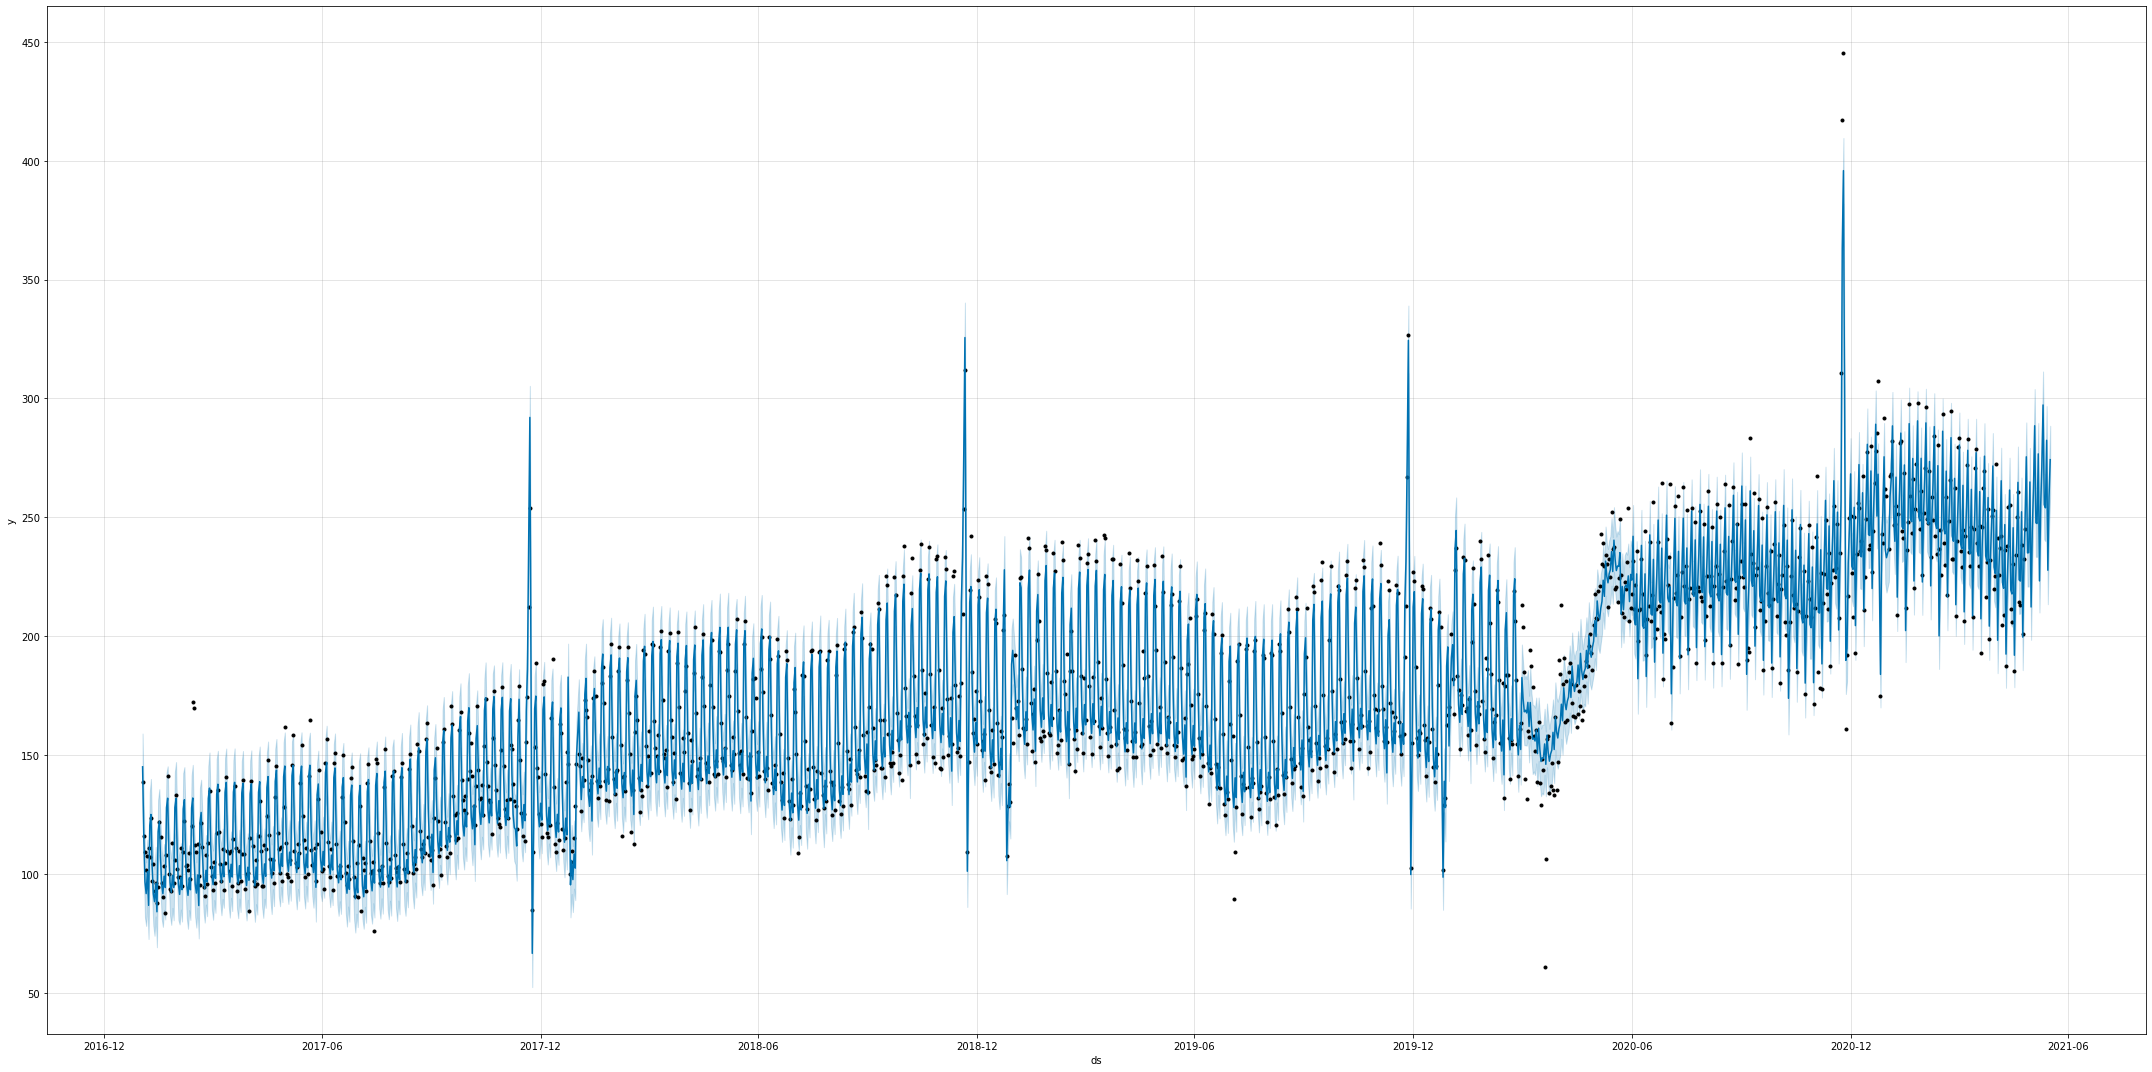

In [14]:
# Plot acutals and predicted
plot(best_model, best_forecast, figsize=(30, 15))
plt.show()

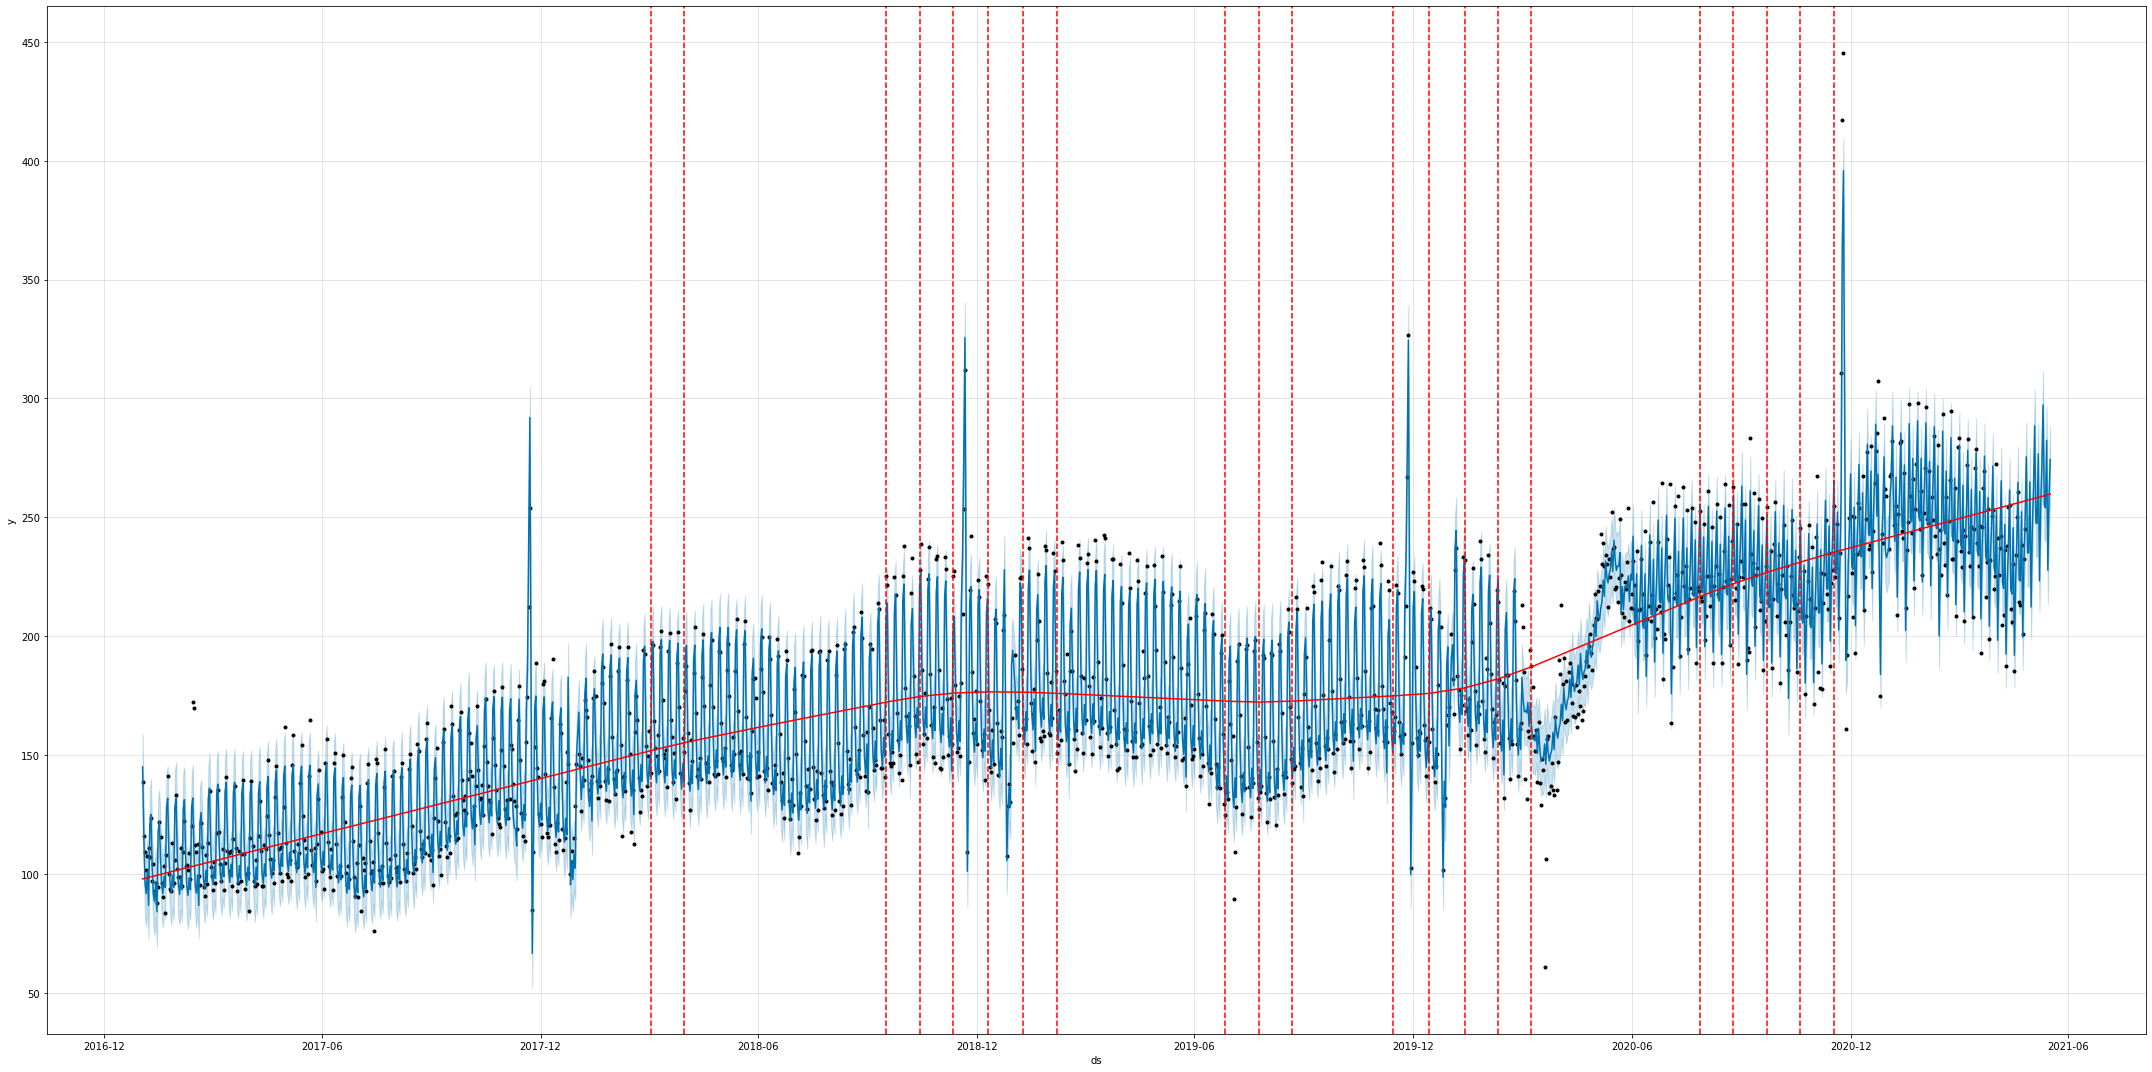

In [15]:
# Plot changepoints and trend
fig = best_model.plot(best_forecast, figsize=(30, 15))
a = add_changepoints_to_plot(fig.gca(), best_model, best_forecast)
plt.show()

/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/adiagarwal/.local/share/virtualenvs/dataland-dagster-qDqWmbRN/lib/python3.8/s

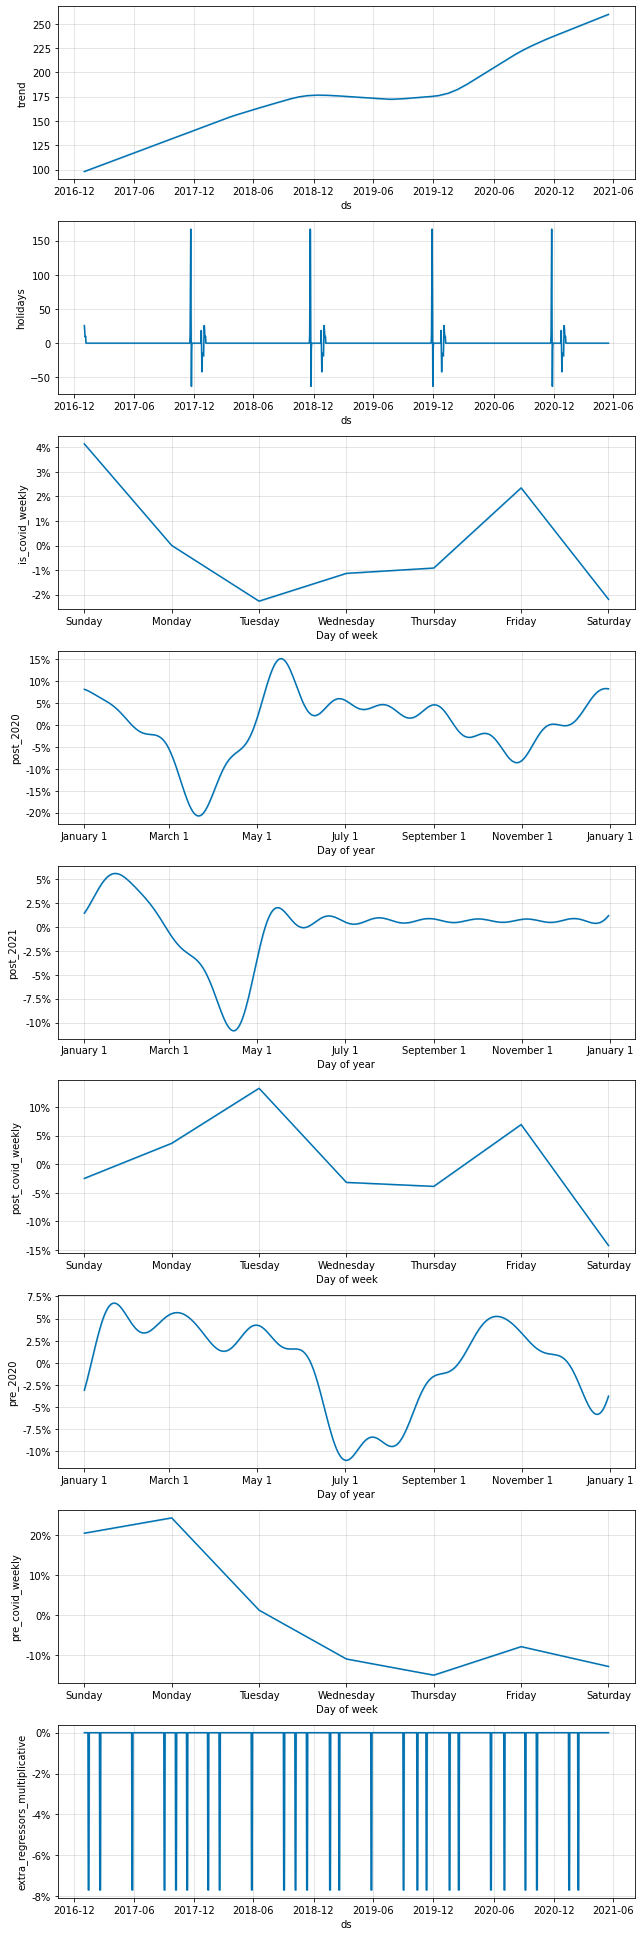

In [16]:
# Plot components (trend, yearly seasonality, and weekly seasonality)
fig2 = best_model.plot_components(best_forecast)

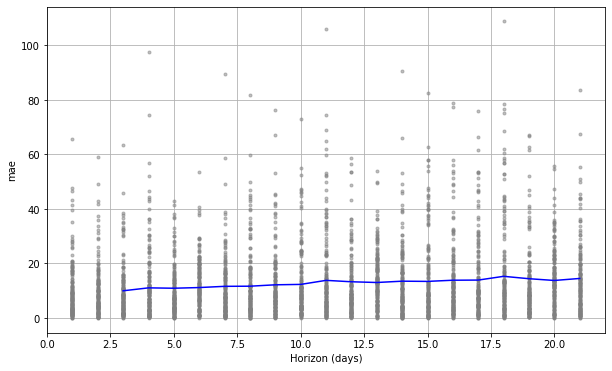

In [17]:
# Plot cross validation metric
cvfig = plot_cross_validation_metric(best_cv_results, metric='mae')

In [18]:
# Yield model back to Dagster.
dm.yield_result(value=best_model, output_name="model")

# Yield Forecast DataFrame back to Dagster.
transform_best_forecast = pd.DataFrame()
transform_best_forecast.loc[:,"ds"] = best_forecast.loc[:,"ds"]
transform_best_forecast.loc[:,"yhat"] = inv_boxcox(best_forecast.loc[:,"yhat"], lam) - 1
transform_best_forecast.loc[:,"yhat_upper"] = inv_boxcox(best_forecast.loc[:,"yhat_upper"], lam) - 1
transform_best_forecast.loc[:,"yhat_lower"] = inv_boxcox(best_forecast.loc[:,"yhat_lower"], lam) - 1

forecast = pd.DataFrame()
forecast = pd.merge(orders[["ds", "y"]], transform_best_forecast, how='left', on='ds')

### Preparing Expected orders data
    -Grouping data by the day of the week ex: all mondays, tuesdays and so on 
    -Dividing those groups into seven different datasets and calculating four week day average
    -Concatinating all the seven dataframes back to one and then merging back to the sales data
    -Final Sales data prepration with columns: ds, y, yexpected, yhat, yhat_upper, yhat_lower 

In [19]:
expected = pd.DataFrame()
sales_forecast = pd.DataFrame()
for i in range(7):
    day_df = forecast[forecast.ds.dt.dayofweek == i]
    day_df.index= range(len(day_df))
    week = 3
    while(week > 0):
        day_df['yexpected'] = day_df.y.rolling(4).mean()
        day_df['yexpected'] = day_df['yexpected'].shift(periods=1)
        day_df['y'][len(day_df) - week] = day_df['yexpected'][len(day_df) - week]
        day_df['yexpected'] = day_df.y.rolling(4).mean()
        day_df['yexpected'] = day_df['yexpected'].shift(periods=1)
        week = week - 1
    expected = expected.append(day_df, ignore_index=True)

sales_forecast = pd.merge(forecast, expected[['ds','yexpected']], on='ds', how='left').fillna(0)
sales_forecast = sales_forecast.reindex(['ds','y','yexpected','yhat','yhat_upper','yhat_lower'], axis = 1)

<ipython-input-19-83d755b123bc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['yexpected'] = day_df.y.rolling(4).mean()
<ipython-input-19-83d755b123bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['yexpected'] = day_df['yexpected'].shift(periods=1)
<ipython-input-19-83d755b123bc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [20]:
dm.yield_result(value=sales_forecast[["ds", "y", "yexpected", "yhat", "yhat_lower", "yhat_upper"]], output_name="df")

,ds,y,yexpected,yhat,yhat_lower,yhat_upper
0,2017-01-02,862,0.00,919.926865,791.806846,1053.746682
1,2017-01-03,662,0.00,662.996204,548.247488,783.680750
2,2017-01-04,605,0.00,506.216877,395.488338,616.692508
3,2017-01-05,546,0.00,469.031913,370.728533,570.945172
4,2017-01-06,591,0.00,539.794823,432.030734,649.056443
...,...,...,...,...,...,...
1580,2021-05-13,0,1597.00,2103.384898,1933.527512,2275.517896
1581,2021-05-14,0,1906.00,2460.245882,2289.295628,2648.281065
1582,2021-05-15,0,1437.25,1790.009278,1626.608405,1960.137983
1583,2021-05-16,0,1857.50,2156.396560,1977.848254,2334.811749


In [21]:
# QC predicted v/s actual
sales_forecast["delta"] = sales_forecast["y"] - sales_forecast["yhat"]
sales_forecast["abs_%error"] = np.abs(sales_forecast["delta"]/sales_forecast["y"]) * 100
sales_forecast.tail(42)

,ds,y,yexpected,yhat,yhat_upper,yhat_lower,delta,abs_%error
1543,2021-04-06,1960,2317.75,2244.240637,2420.310762,2060.552219,-284.240637,14.502073
1544,2021-04-07,1529,1791.50,1731.692693,1890.925663,1579.580045,-202.692693,13.256553
1545,2021-04-08,1578,1804.75,1702.450477,1859.524324,1539.200493,-124.450477,7.886595
1546,2021-04-09,1892,2111.75,2017.625906,2174.922966,1837.064725,-125.625906,6.639847
1547,2021-04-10,1341,1594.75,1395.983487,1553.336084,1247.103391,-54.983487,4.100185
1548,2021-04-11,1912,1900.50,1722.292167,1871.403340,1564.298477,189.707833,9.921958
1549,2021-04-12,2109,2119.50,1900.445014,2068.687456,1736.488346,208.554986,9.888809
1550,2021-04-13,2118,2190.75,2195.652360,2366.583650,2017.251361,-77.652360,3.666306
1551,2021-04-14,1605,1703.75,1694.208464,1859.680339,1533.800464,-89.208464,5.558160
1552,2021-04-15,1545,1746.00,1675.093687,1851.783970,1521.466660,-130.093687,8.420303


#### END